In [3]:
!pip install arch
# Import necessary libraries
import yfinance as yf

# Download data with yfinance
ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2024-04-30'

data = yf.download(ticker, start=start_date, end=end_date)

# Print the first few rows of the data
print(data.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 24.6 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.454504  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.465665  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.362819  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.351056  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.393281  447610800


In [4]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model

# Download data with yfinance
ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2024-04-30'

data = yf.download(ticker, start=start_date, end=end_date)

# Calculate log returns
data['log_return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

# Data preprocessing
returns = data['log_return'].dropna()

# Fit GARCH Model
am = arch_model(returns, mean='Zero', vol='Garch', p=1, q=1)
res = am.fit(disp='off')

# Forecast volatility
forecasts = res.forecast(horizon=5)

# Print the forecasted volatility
print(forecasts.mean.iloc[-1, :])

[*********************100%***********************]  1 of 1 completed

h.1    0.0
h.2    0.0
h.3    0.0
h.4    0.0
h.5    0.0
Name: 2024-04-29 00:00:00, dtype: float64



/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003129. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [5]:
# Data preprocessing to remove NaN or infinite values
from arch import arch_model
import yfinance as yf
import numpy as np
import pandas as pd

data = data.dropna()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Define function for model evaluation
def evaluate_model(data):
    # Fit GARCH model
    am = arch_model(data['log_return'], mean='Zero', vol='Garch', p=1, q=1, rescale=True)
    res = am.fit(disp='off')

    # Calculate AIC and BIC
    aic = res.aic
    bic = res.bic

    # Perform backtesting
    residuals = data['log_return'] - res.conditional_volatility
    res_t = residuals / res.conditional_volatility
    backtest = (res_t**2).sum()

    # Out-of-sample testing
    data_length = len(data)
    train_size = int(0.8 * data_length)
    train_data = data[:train_size]
    test_data = data[train_size:]

    res_oos = am.fit(last_obs=train_data.index[-1], disp='off')
    forecast = res_oos.forecast(start=train_data.index[-1], horizon=len(test_data))

    # Calculate out-of-sample forecast error
    forecast_vol = forecast.residual_variance.iloc[-1, :]
    error = (test_data['log_return'] - forecast_vol).dropna()

    return aic, bic, backtest, error

# Evaluate the GARCH model using log returns data
aic, bic, backtest, forecast_error = evaluate_model(data)

# Print the evaluation results
print(f'AIC: {aic}')
print(f'BIC: {bic}')
print(f'Backtesting Result: {backtest}')

AIC: 13824.929660443237
BIC: 13843.49822677548
Backtesting Result: 3599.0860075603205


#2nd Approach

In [7]:
!pip install pmdarima
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import yfinance as yf

from arch import arch_model
from pmdarima.model_selection import train_test_split
from scipy.stats import chi2, jarque_bera
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.3 MB/s eta 0:00:00


In [8]:
spy = yf.Ticker("SPY")
hist = spy.history(start = "2010-01-04", end = "2020-02-01")
df = pd.DataFrame(hist, columns=['Close'])
df.head

<bound method NDFrame.head of                                 Close
Date                                 
2010-01-04 00:00:00-05:00   86.315994
2010-01-05 00:00:00-05:00   86.544487
2010-01-06 00:00:00-05:00   86.605415
2010-01-07 00:00:00-05:00   86.970978
2010-01-08 00:00:00-05:00   87.260422
...                               ...
2020-01-27 00:00:00-05:00  300.934174
2020-01-28 00:00:00-05:00  304.087738
2020-01-29 00:00:00-05:00  303.836548
2020-01-30 00:00:00-05:00  304.822601
2020-01-31 00:00:00-05:00  299.287628

[2537 rows x 1 columns]>

In [9]:
# Convert prices to log returns
df['Return'] = np.pad(np.diff(np.log(df['Close'])) * 100, (1, 0), 'constant', constant_values=np.nan)

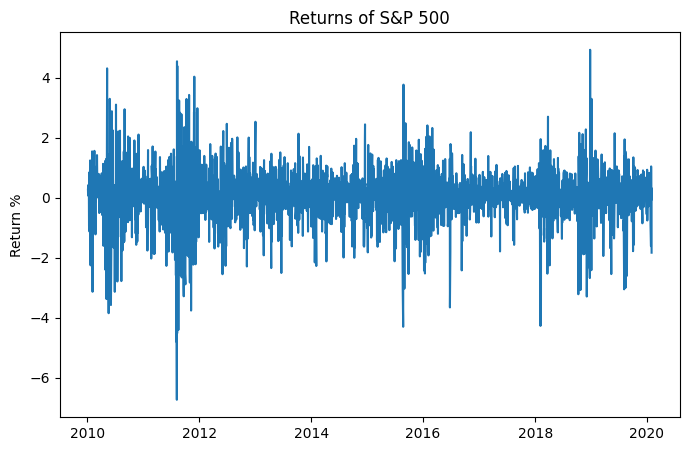

In [10]:
# Add trace plot
plt.figure(figsize=(8,5))
plt.plot(df['Return'])
plt.ylabel("Return %")
plt.title('Returns of S&P 500');

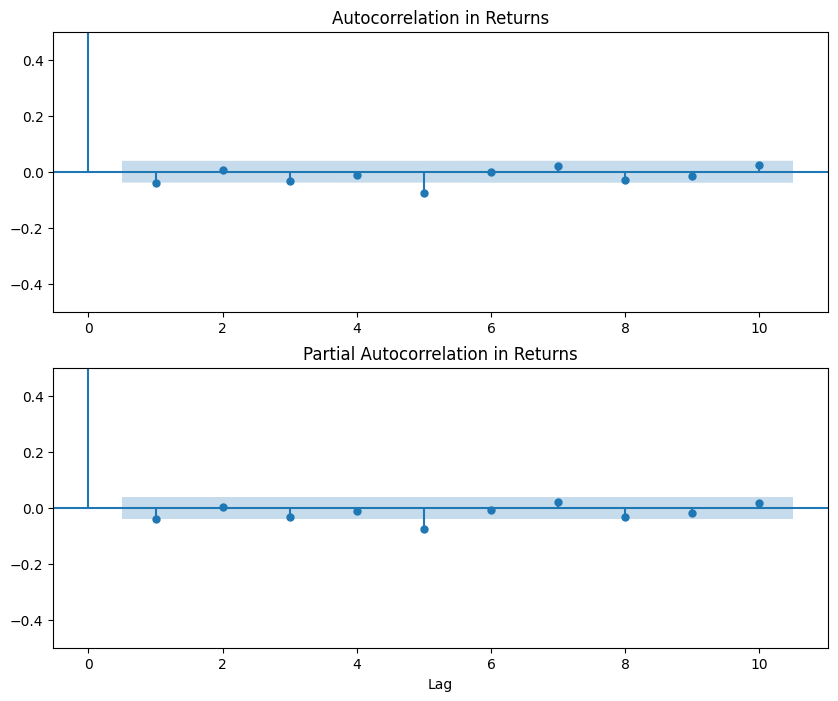

In [11]:
# Plot ACF and PACF
diff_ts = df['Return'].iloc[1:]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_ts, ax=ax1, lags=10)
ax1.set_ylim(-0.5, .5)
ax1.set_title("Autocorrelation in Returns")
plot_pacf(diff_ts, ax=ax2, lags=10)
ax2.set_ylim(-0.5, .5)
ax2.set_xlabel("Lag")
ax2.set_title("Partial Autocorrelation in Returns")

plt.show()

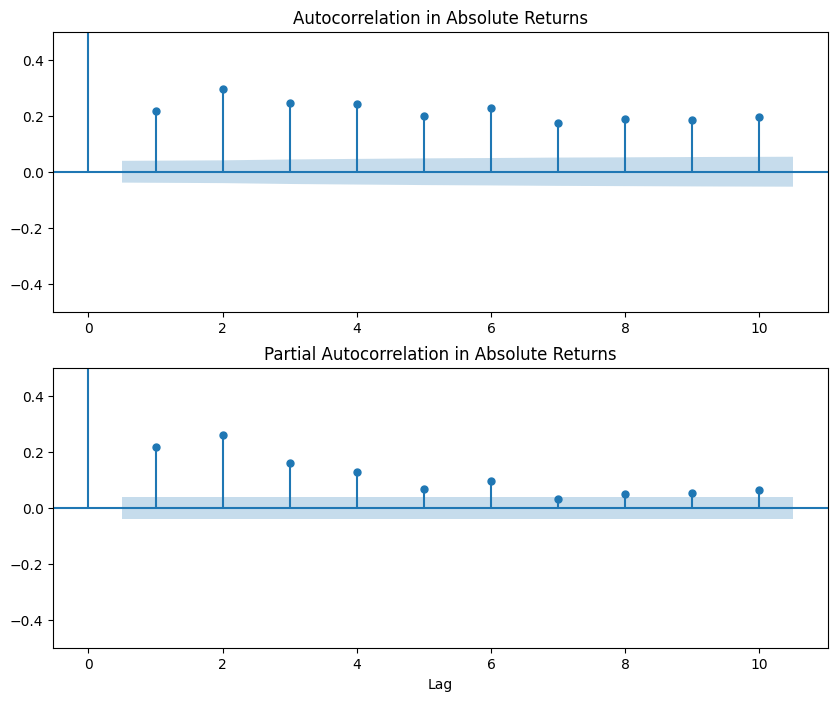

In [12]:
# Plot ACF and PACF of absolute returns
abs_returns = diff_ts.abs()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(abs_returns, ax=ax1, lags=10)
ax1.set_ylim(-.5, .5)
ax1.set_title("Autocorrelation in Absolute Returns")
plot_pacf(abs_returns, ax=ax2, lags=10)
ax2.set_ylim(-.5, .5)
ax2.set_title("Partial Autocorrelation in Absolute Returns")
ax2.set_xlabel("Lag")

plt.show();

In [13]:
def mcleod_li_test(x, k):
    """
    Calculates the McLeod-Li test statistic for a time series with k lags.
    Returns the test statistic and its p-value.
    """
    n = len(x)
    x_sq = x ** 2
    x_sum = np.sum(x_sq)
    x_lag_sum = np.sum(x_sq[:-k])
    test_stat = n * (n + 2) * x_lag_sum / (x_sum ** 2)
    df = k
    p_value = 1 - chi2.cdf(test_stat, df)
    return test_stat, p_value
test_stat, p_value = mcleod_li_test(abs_returns, 50)
print("McLeod-Li test statistic: ", test_stat)
print("p-value: ", p_value)

McLeod-Li test statistic:  2929.7558532260214
p-value:  0.0


In [14]:
# Fit GARCH (1,1)
y_train, y_test = train_test_split(abs_returns, train_size= 0.8)

garch_mod = arch_model(y_train, mean = "Zero",  vol='Garch', p=1, q=1, rescale=False)
res_garch = garch_mod.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4134.425967436971
Iteration:      2,   Func. Count:     14,   Neg. LLF: 3069.30726037144
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3281.6643662333977
Iteration:      4,   Func. Count:     25,   Neg. LLF: 2411.9980849832336
Iteration:      5,   Func. Count:     30,   Neg. LLF: 2403.7271175515907
Iteration:      6,   Func. Count:     34,   Neg. LLF: 2403.6961751862386
Iteration:      7,   Func. Count:     38,   Neg. LLF: 2403.6932087642103
Iteration:      8,   Func. Count:     42,   Neg. LLF: 2403.693073484008
Iteration:      9,   Func. Count:     46,   Neg. LLF: 2403.693010254341
Iteration:     10,   Func. Count:     49,   Neg. LLF: 2403.6930102544325
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2403.693010254341
            Iterations: 10
            Function evaluations: 49
            Gradient evaluations: 10


In [15]:
# Model summary
print(res_garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2403.69
Distribution:                  Normal   AIC:                           4813.39
Method:            Maximum Likelihood   BIC:                           4830.23
                                        No. Observations:                 2028
Date:                Mon, Oct 21 2024   Df Residuals:                     2028
Time:                        12:58:58   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0309  8.422e-03      3.667  2.450e-04 [1.

In [16]:
# Forecast the test set
yhat = res_garch.forecast(horizon = y_test.shape[0], reindex=True)

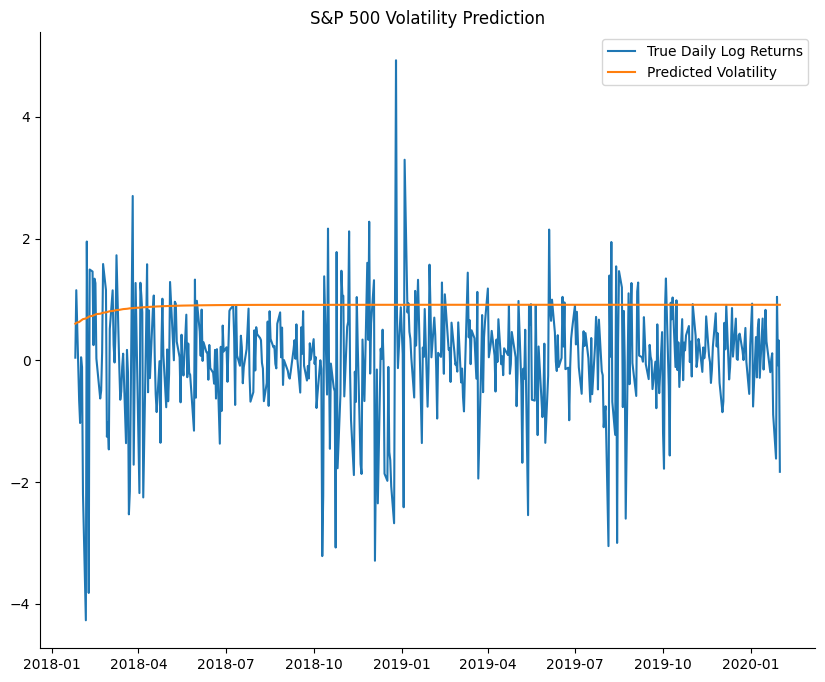

In [17]:
fig,ax = plt.subplots(figsize=(10,8))
ax.spines[['top','right']].set_visible(False)
# Plot test set returns
plt.plot(diff_ts[-y_test.shape[0]:])
# Plot volatility estimates for test set
plt.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
plt.title('S&P 500 Volatility Prediction')
plt.legend(['True Daily Log Returns', 'Predicted Volatility'])

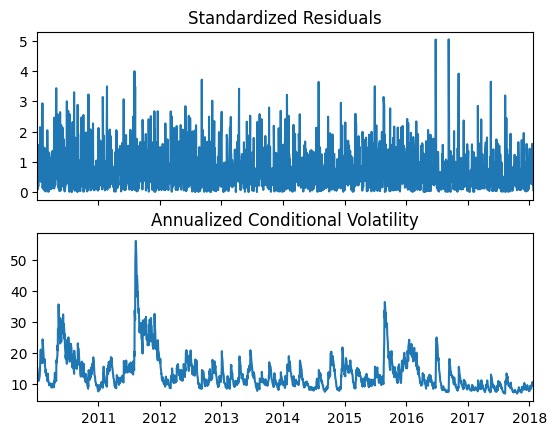

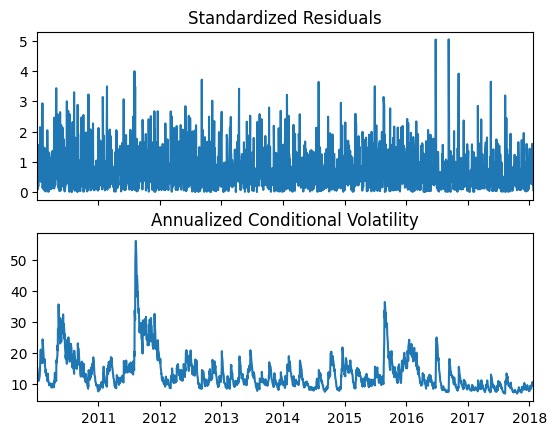

In [18]:
# Conditional volatility by model fitting
res_garch.plot(annualize="D")

In [19]:
rolling_preds = []

for i in range(y_test.shape[0]):
    train = abs_returns[:-(y_test.shape[0]-i)]
    model = arch_model(train, p=1, q=1, rescale = False)
    model_fit = model.fit(disp='off')
    # One step ahead predictor
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_preds.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_preds = pd.Series(rolling_preds, index=y_test.index)

Text(0.5, 1.0, 'S&P 500 Rolling Volatility Prediction')

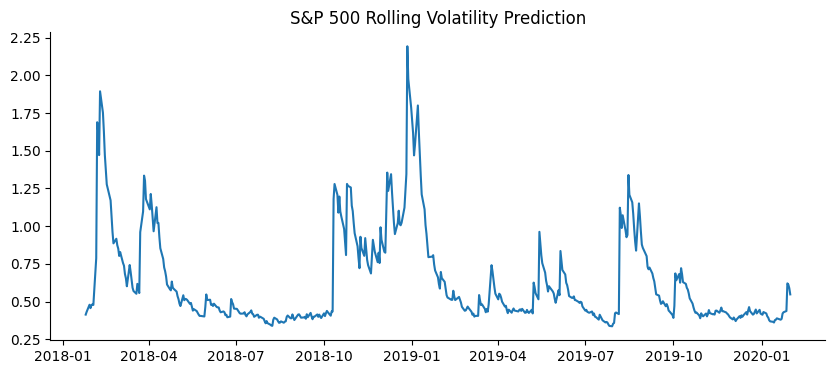

In [20]:
# Plot of predicted test data rolling volatility predictions
fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_preds)
plt.title('S&P 500 Rolling Volatility Prediction')


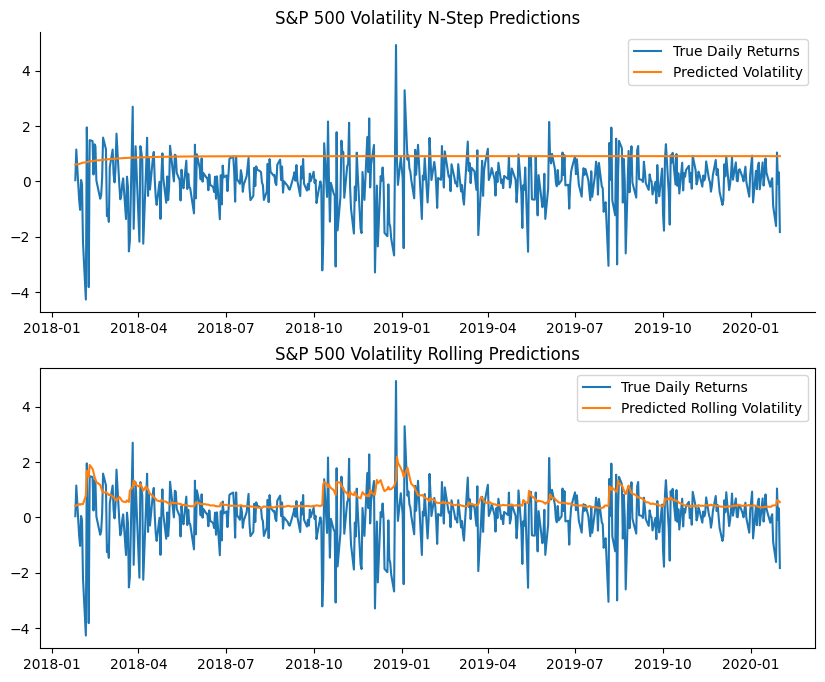

In [21]:
# Compare n-step-ahead and one-step-ahead rolling predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.spines[['top','right']].set_visible(False)
ax1.plot(diff_ts[-y_test.shape[0]:])
ax1.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
ax1.set_title("S&P 500 Volatility N-Step Predictions")
ax1.legend(['True Daily Returns', 'Predicted Volatility'])

ax.spines[['top','right']].set_visible(False)
ax2.plot(diff_ts[-y_test.shape[0]:])
ax2.plot(y_test.index,rolling_preds)
ax2.set_title("S&P 500 Volatility Rolling Predictions")
ax2.legend(['True Daily Returns', 'Predicted Rolling Volatility'])
plt.show()

In [22]:
# Calculate the standardized residuals on the test data
std_resid = res_garch.resid / res_garch.conditional_volatility

# Perform Jarque-Bera test using scipy.stats
jb_test = jarque_bera(std_resid)
print("Jarque-Bera test statistic:", jb_test[0])
print("p-value:", jb_test[1])

Jarque-Bera test statistic: 1950.8717323975773
p-value: 0.0
